In [1]:
# Silence tensorflow deprecation error messages

from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

In [2]:
# Set up paths of scripts

import sys
sys.path.append("../data/")
sys.path.append("../utils/")
sys.path.append("../models/")
sys.path.append("../simulation/")
sys.path.append("../visualization/")


In [3]:
from binaural import Binaural
import numpy as np
from custom_timer import Timer
import data_generator_lib
import random
import pandas as pd
import multiprocessing as mp
import data_to_raw_numpy
import librosa
from librosa import display
import matplotlib.pyplot as plt
import gccphat
from simulation import Simulation
from IPython.display import HTML
from plotting import plotting
import constants
import final_models
import IPython.display as ipd

0it [00:00, ?it/s]Using TensorFlow backend.


===============================================================================


# Facing the Music
## Binaural Sound Localisation with Machine Learning

===============================================================================

# Let's synthesize some data!

## Get a sound source from the Google Speech Commands dataset

In [4]:
# Download and select an arbitrary sound source from Google Speech Commands Dataset
# This may take a while depending on your internet connection

source = data_generator_lib.get_data(1)[5] 

/home/kevin/anaconda3/envs/new_env/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


Text(0.5, 1.0, 'Mono Source Signal')

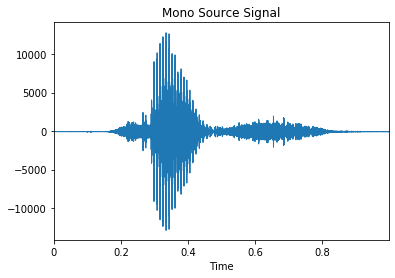

In [5]:
# Plot the mono sound source

display.waveplot(source.data.astype('float64'),
                 source.fs)
plt.title('Mono Source Signal')

In [6]:
# Hear the mono sound source

ipd.Audio(source.data, rate=source.fs) 

## Set up a room and record the audio 

In [7]:
# Set up constant parameters for the room 

# In this instance we have:
# - 4x4x4 meter room
# - reflection order of 17
# - microphone height of 2m
# - inter microphone distance of 0.2m 



room = Binaural(room_dim=np.r_[4., 4., 4.],
             max_order=17,
             speed_of_sound=343,
             inter_aural_distance=0.2,
             mic_height=2)

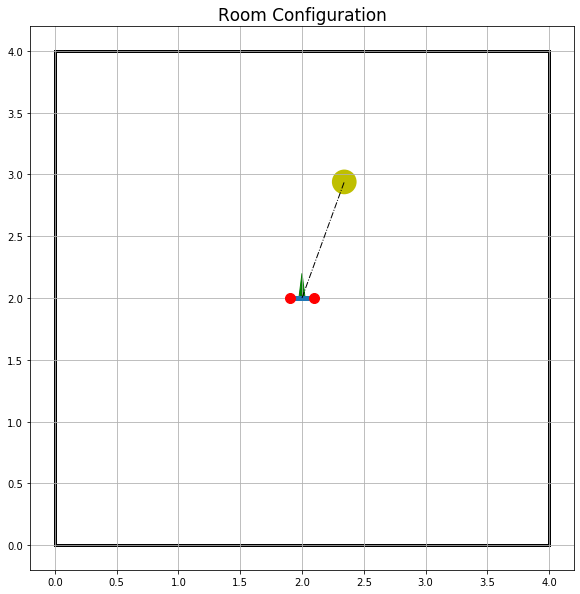

True Azimuth: 70.0


(array([-0.07327355,  0.05586979,  0.02076095, ..., -0.03335955,
        -0.02243615,  0.01353086]),
 array([ 0.11299306, -0.04516514, -0.08713911, ...,  0.09704706,
         0.04032829, -0.08274733]),
 70.0,
 '70.0.wav')

In [8]:
# Here we generate a stereo wav file. This is the resulting audio of 
# artificially placing the mono speech recording in our predefined room

# The plot shows the room configuration
# - yellow dot is the sound source 
# - red dots are the microphones 


room.generate_impulse_pair(source_azimuth_degrees=70,
                           source_distance_from_room_centre=1,
                           SNR=0,
                           RT60=1,
                           mic_centre=np.array([2, 2]),
                           mic_rotation_degrees=0,
                           fs=source.fs,
                           source_signal=source.data,
                           plot_room=True,
                           plot_impulse=False,
                           write_wav=True,
                           wav_name="house_spatial_")

In [9]:
# Hear the speech signal now that it has been "placed"
# in the room


ipd.Audio("house_spatial_70.0.wav")

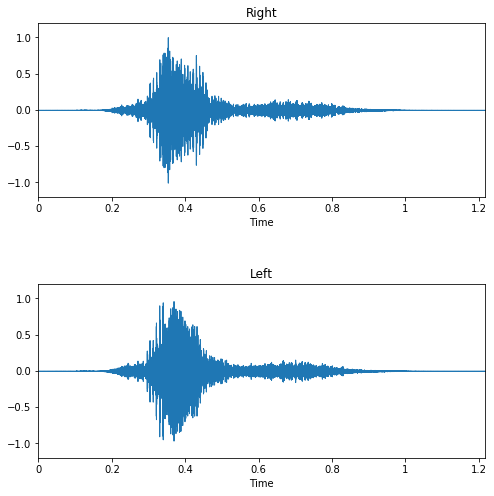

In [10]:
# Plot the new stereo "spatialised" audio

y, sr = librosa.load("house_spatial_70.0.wav", mono=False)
plt.figure(figsize=(8,8))
plt.subplots_adjust(hspace=0.5)
plt.subplot(2,1,1)
plt.title("Right")
plt.ylim(-1.2,1.2)
display.waveplot(y[0],sr)
plt.subplot(2,1,2)
plt.title("Left")
plt.ylim(-1.2,1.2)
display.waveplot(y[1],sr)

## Generalised Cross-Correlation with Phase-Transfom

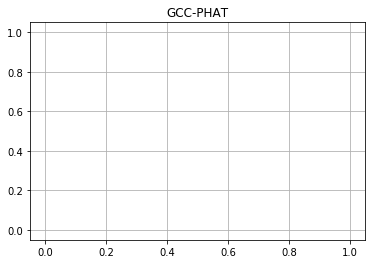

In [13]:
# compute time delay with GCC-PHAT

tau, gcc = gccphat.gcc_phat(y[1], y[0], fs=sr)
plt.plot(gcc)
plt.title("GCC-PHAT")
plt.grid()

In [14]:
# Compute Direction of Arrival using GCC-PHAT

theta = gccphat.tdoa(y[0], y[1], fs=sr)
print("Direction of Arrival: {doa} degrees".format(doa=np.round(theta,3)))

Direction of Arrival: 175.224 degrees


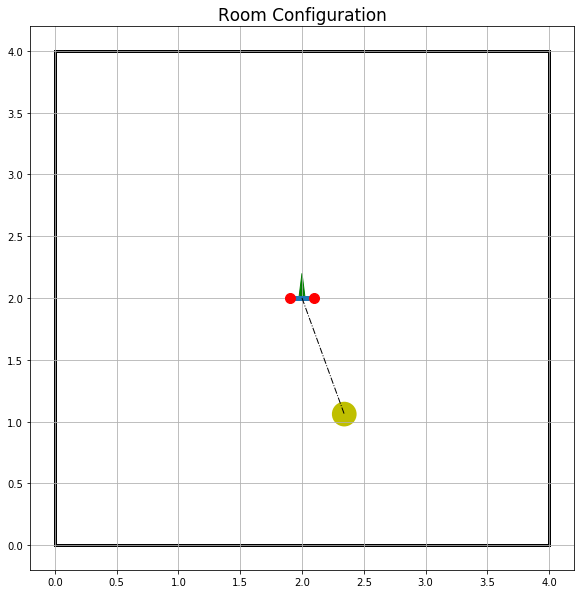

True Azimuth: 290.0
Direction of Arrival: 175.224 degrees


In [15]:
room.generate_impulse_pair(source_azimuth_degrees=290,
                           source_distance_from_room_centre=1,
                           SNR=0,
                           RT60=1,
                           mic_centre=np.array([2, 2]),
                           mic_rotation_degrees=0,
                           fs=source.fs,
                           source_signal=source.data,
                           plot_room=True,
                           plot_impulse=False,
                           write_wav=True,
                           wav_name="house_spatial_")

y_290, sr_290 = librosa.load("house_spatial_290.0.wav", mono=False)

theta_290 = gccphat.tdoa(y_290[0], y_290[1], fs=sr_290)
print("Direction of Arrival: {doa} degrees".format(doa=np.round(theta_290,3)))



## Front-Back Confusion


<img src="frontbackconfusion.png" width="512">

# How to fix this?

## Front back labelling

In [16]:
y_290 = librosa.resample(y_290, sr_290, 8000)

In [17]:
prediction = final_models.gcc_dsp().predict(y_290)
print("Possible Directions of Arrival: {doa} degrees".format(doa=prediction))

Model: gcc_dsp
Possible Directions of Arrival: [70.0, 290.0] degrees


##  Rotations!

<img src="rotationmodel_diagram.png" width="700">

# The full solution: GCC-PHAT + ConvNet + Rotations

In [18]:
%%capture

source_distance = 1
source_azimuth = 70



sim = Simulation(directory="notebook_simulation",
                 source_azimuth=source_azimuth,
                 source_distance=source_distance,
                 model="gcc_cnn")

prediction = sim.simulate()

plot = plotting(room_dim=constants.room_dim,
                source_distance=source_distance,
                source_azimuth=source_azimuth,
                mic_centre=sim.mic_centre,
                rotation_list=sim.rotation_list,
                prediction_list=sim.predictions,
                prediction=sim.prediction)

demo = plot.plot_room(notebook=True)

print("Final Prediction: {prediction}".format(prediction=prediction))


In [19]:
demo

In [48]:
%%capture




sim_290 = Simulation(directory="notebook_simulation",
                 source_azimuth=290,
                 source_distance=1,
                 model="gcc_cnn")

prediction_290 = sim_290.simulate()

plot_290 = plotting(room_dim=constants.room_dim,
                source_distance=1,
                source_azimuth=290,
                mic_centre=sim_290.mic_centre,
                rotation_list=sim_290.rotation_list,
                prediction_list=sim_290.predictions,
                prediction=sim_290.prediction)

demo_290 = plot_290.plot_room(notebook=True)

print("Final Prediction: {prediction}".format(prediction=prediction_290))

In [49]:
demo_290